In [3]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 
plt.rcParams["figure.figsize"] = (3,3)
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp

Bifurcations de populations de neurones
======================

Le but de ce projet est de simuler l'évolution de l'activité moyenne de groupes de neurones en intéraction, à l'aide d'un modèle simplifié de *Wilson-Cowan*. En notant $x=(x_1,...,x_i,..., x_n)\in \mathbb{R}^n$ le vecteur contenant l'activité moyenne de chacun des $n$ groupes de neurones, ce modèle s'écrit (en grandeurs normalisées)
$$
\tau \dot x = - x + S(Wx + d^{\rm ext})
$$
où $\tau$ est une constante de temps, $W \in \mathbb{R}^{n\times n}$ est une matrice décrivant les intéractions entre groupes de neurones, $d^{\rm ext}\in \mathbb{R}^n$ peut contenir des stimulis/perturbations extérieurs impactant chaque groupe, et $S: \mathbb{R}^n \to \mathbb{R}^n$ est de la forme
$$
S({\rm x}_1,...,{\rm x}_i ,...,{\rm x}_n) = (s_1({\rm x}_1),...,s_i({\rm x}_i),...,s_n({\rm x}_n))
$$
où $s_i:\mathbb{R}\to \mathbb{R}$ sont des fonctions dîtes d'*activation*.

Ces fonctions d'activation permettent de modéliser le fait que l'activité environnante d'un groupe de neurone doit atteindre un certain seuil avant d'exciter ce groupe. Des choix courants de fonctions d'activation sont la tangente hyperbolique ou des sigmoides de la forme
$$
s({\rm x}) = \frac{1}{1+ e^{-a(x-\theta)}}-\frac{1}{1+e^{a\theta}}
$$
où $\theta$ représente le seuil d'activation et $a$ sa pente, comme illustré ci-dessous. 

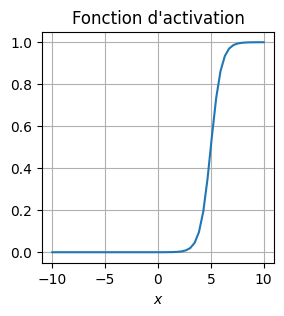

In [4]:
def sigmoid(x):
    a = 2.0   # la pente au niveau du seuil est a/4
    theta = 5.0  # seuil
    return 1/(1+np.exp(-a*(x-theta)))-1/(1+np.exp(a*theta))

x = np.linspace(-10,10)
plt.figure()
plt.plot(x,sigmoid(x))
plt.grid(True)
plt.xlabel('$x$')
plt.title("Fonction d'activation")
plt.show()

Notons que si l'on réécrit l'équation différentielle composante par composante, on trouve que la dynamique de chaque groupe de neurone s'écrit
$$
\tau \dot x_i = -x_i + s_i\left(\sum_{j=1}^n w_{ij}x_j + d_{i}^{\rm ext}\right)
$$

**Question 1** Justifier que si les fonctions d'activation $s_i:\mathbb{R}\to \mathbb{R}$ sont bornées (minorées et majorées) alors toutes les solutions maximales $t\mapsto x(t)$ sont définies sur $\mathbb{R}$ et sont bornées. Relier la borne de $t\mapsto x_i(t)$ à la borne de $s_i$ pour chaque $i$. 

Soit M la borne sup de $|s_i(t)|$, on obtient alors l'inégalité suivante:

$$- x_i(t) - M \le \dot{x_i}(t) \le - x_i(t) + M$$

ce qui donne en multipliant par le facteur intégrant $e^t$:

$$-Me^t \le \frac{d(x_i(t)e^t)}{dt} \le Me^t$$

puis en intégrant entre 0 et t on obtient:

$$-M - x_i(0)e^{-t} \le x_i(t) \le M - x_i(0)e^{-t}$$

et on en déduit que:

$$|x_i(t)| \le M + |x_i(0)|$$

Ainsi $x(t)$ est borné, donc n'explose pas en temps fini, donc les solutions maximales sont définies sur $\mathbb{R}$.

On pourrait également invoquer le critère d'existence globale pour justifier que les solutions maximales sont définies sur $\mathbb{R}$ entier.


Pour simplifier, on étudie ce système en dimension 2, c'est-à-dire avec deux groupes de neurones: le premier ayant un effet *excitant* et le deuxième *inhibant*. On traduit cela par la matrice d'interconnection suivante.

In [5]:
W = np.array([[5.0, -4.0], [8.0, -1.0]])
print(W)

[[ 5. -4.]
 [ 8. -1.]]


On fixe aussi $s_1=s_2$ données par la sigmoide ci-dessus, ainsi que $\tau=1$ puisque faire varier $\tau$ ne change que l'échelle de temps. On va essayer d'étudier et exploiter la grande richesse de comportements asymptotiques possibles pour différentes valeurs de $d^{\rm ext}$.

Points d'équilibre
================

On commence par considérer $d^{\rm ext}$ constant. Ses composantes $d_1^{\rm ext}$ et $d_2^{\rm ext}$ peuvent donc être vus comme des paramètres du système. Les points d'équilibre $x^{\rm eq}\in \mathbb{R}^n$ se caractérisent alors par l'équation
$$
x^{\rm eq} = S(W x^{\rm eq} + d^{\rm ext})
$$
La fonction suivante trace les points $(x_1,x_2)$ tels que $-x_1+s(w_{11}x_1+w_{12}x_2+d_1^{\rm ext})=0$ (en rouge) et $-x_2+s(w_{21}x_1+w_{22}x_2+d_2^{\rm ext})=0$ (en vert) pour des valeurs de $d^{\rm ext}$ à choisir.

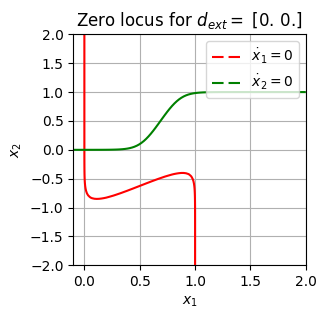

In [6]:
def plot_zero_locus(d_ext):
    grid_x1 = np.linspace(-0.1,2.0,100)
    grid_x2 = np.linspace(-2.0,2.0,100)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)

    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    plt.figure()
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()
    return


d_ext = np.array([0.0,0.0])  # A CHOISIR
plot_zero_locus(d_ext)

**Question 2** Identifier le point d'équilibre du système pour $d^{\rm ext}=0$ et étudier sa stabilité. 

Le point d'équilibre est le point ($x_1$, $x_2$) tel que ($\dot{x_1}$, $\dot{x_2}$) = (0, 0). Ici, le point d'équilibre est (0, 0).

Soit $f: \mathbb{R}^2 \to \mathbb{R}^2$ qui à $x = (x_1, x_2)$ associe $(f_1(x_1, x_2), f_2(x_1, x_2))$ où $f_1(x_1, x_2) = s_1(5x_1 - 4x_2) - x_1$ et $f_2(x_1, x_2) = s_2(8x_1 - x_2) - x_2$ de telle sorte que $\dot{X} = f(X)$.

La jacobienne de f en (0, 0) est :

In [7]:
J_f = np.array([[10*np.exp(10)/(1 + np.exp(10))**2 - 1, -8*np.exp(10)/(1 + np.exp(10))**2],
                [16*np.exp(10)/(1 + np.exp(10))**2, -2*np.exp(10)/(1 + np.exp(10))**2 - 1]])
print(J_f)

[[-9.99546042e-01 -3.63166462e-04]
 [ 7.26332924e-04 -1.00009079e+00]]


Soit $J_f \simeq -I$.

Ainsi, $det(J_f) \simeq 1$ et $Tr(J_f) \simeq -2$, donc $J_f$ admet des valeurs propres à partie réelle strictement négative, ainsi, le point d'équilibre (0, 0) est stable.


**Question 3** Tester d'autres valeurs de $d^{\rm ext}$. Par exemple, fixer $d^{\rm ext}_2=4$, et faire varier $d^{\rm ext}_1$ entre 3 et 8. Qu'observe-t-on sur le nombre de points d'équilibre ? Pour $d^{\rm ext}=(6,4)$, on trace ci-dessous le portrait de phase. Retrouver graphiquement les points d'équilibre et intuiter leur stabilité. Quels sont les seuls comportements asymptotiques possibles des solutions pour cette valeur constante de $d^{\rm ext}$ ?

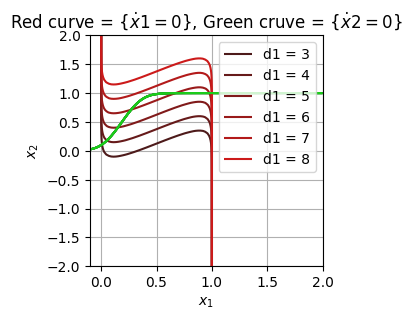

In [8]:
def question_3():

    d2 = 4
    plt.figure()
    Legend_elmts = []

    for d1 in range(3, 9):

        grid_x1 = np.linspace(-0.1,2.0,100)
        grid_x2 = np.linspace(-2.0,2.0,100)
        X1, X2 = np.meshgrid(grid_x1,grid_x2)

        X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d1)
        X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d2)

        C1 = plt.contour(X1, X2, X1dot, 0, colors = (0.1*d1, 0.1, 0.1))
        C2 = plt.contour(X1, X2, X2dot, 0, colors = (0.1, 0.1*d1, 0.1))
        h1,_ = C1.legend_elements()
        h2,_ = C2.legend_elements()
        Legend_elmts.append([h1[0], h2[0]])

    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h[0] for h in Legend_elmts],[f'd1 = {i}' for i in range(3, 9)])
    plt.title("Red curve = {$\dot x1 = 0$}, Green cruve = {$\dot x2 = 0$}")
    plt.show()
    
question_3()

On remarque que le nombre de points d'équilibre évolue entre 1 et 3.

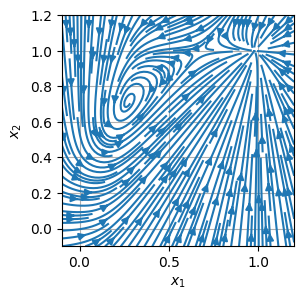

In [19]:
d_ext = np.array([6.0,4.0])  

grid_x1 = np.linspace(-0.1,1.2,70)
grid_x2 = np.linspace(-0.1,1.2,70)
X1, X2 = np.meshgrid(grid_x1,grid_x2)

X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

plt.figure()
plt.streamplot(grid_x1, grid_x2, X1dot, X2dot,density=2)
plt.grid(True)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

Graphiquement, on trouve que les points d'équilibre sont (1, 1), (0.6, 1) et (0.3, 0.7) environ.
Le premier est stable, le deuxième est instable et le troisième est stable.
Les comportements asymptotiques possibles sont la convergence vers les points stables.

Lorsque le nombre et la nature (stabilité) des points d'équilibre changent brusquement avec des modifications de paramètres, on parle de *bifurcation*. De tels phénomènes permettent généralement de produire des comportements asymptotiques extrêmement riches et variés, simplement en faisant varier ces paramètres. Nous en étudions plusieurs exemples dans la suite.

Simulation des trajectoires
================

**Question 4** Compléter la fonction ``solve_euler_explicit`` ci-dessous prenant en entrée une fonction $f: \mathbb{R}\times\mathbb{R}^n \to \mathbb{R}^n$ quelconque, une condition initiale $x_0$, un pas de temps $dt$, les temps initiaux et finaux, et renvoyant e vecteur des temps $t^j$ et de la solution $x^j$ du schéma d'Euler explicite appliqué à $\dot{x}=f(t,x)$.

In [14]:
def solve_euler_explicit(f, x0, dt, t0, tf):
    time=[t0]
    values=[x0]
    t=t0
    x=x0
    while t+dt<=tf:
        x=x+dt*f(t,x)
        t=t+dt
        time.append(t)
        values.append(x)
    return time,values


**Question 5** Expliquer (sans le faire) comment on pourrait trouver numériquement l'ordre de convergence de ce schéma.

Une méthode pour trouver l'ordre de convergence de ce schéma serait:  
    - connaître la solution explicite $X(t)$  
    - choisir un pas de temps $\Delta t$  
    - appliquer le schéma pour déterminer les approximations $X^j$  
    - calculer l'erreur maximale $\epsilon (\Delta t) = max \lVert X^j - X(t_j) \rVert$  
    - afficher le graphique $log(\epsilon)  log(\Delta t)$  
    - l'ordre de convergence du schéma est la valeur de la pente du graphe  
  
Il faut cependant faire tout de même attention à ne pas prendre $\Delta t$ trop petit pour éviter les erreurs d'arrondis des flottants.


**Question 6** On utilise maintenant ``solve_euler_explicit`` pour simuler des trajectoires de neurones lorsque $d^{\rm ext}$ est constant. En vous aidant du portrait de phase de la question 3, illustrer les comportements asymptotiques possibles des solutions pour $d^{\rm ext}=(6,4)$, en choisissant différentes conditions initiales. Lequel ne peut-on pas illustrer numériquement ?

On ne peut pas étudier le comportement asymptotique autour du point $(0.6,1)$.

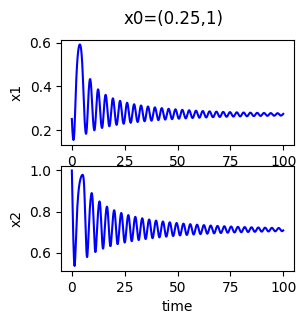

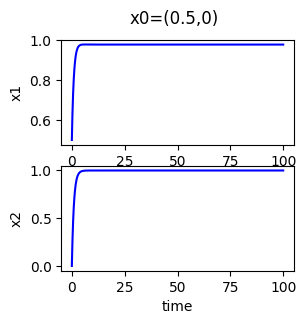

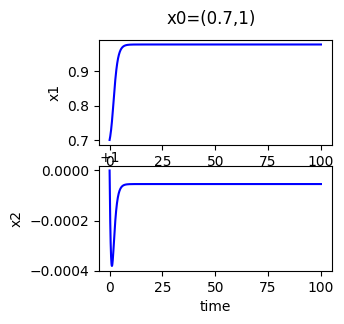

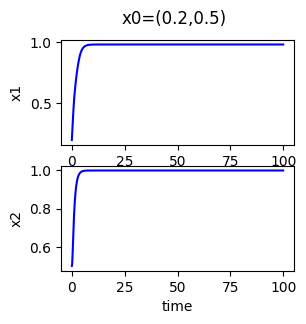

In [40]:
def f_d_ext_constant(t,x):
    d_ext = np.array([6.0,4.0])
    return -x + sigmoid(np.dot(W,x)+d_ext)
dt = 0.1
t0, tf = 0.0, 100.0

x0 = np.array([0.25,1])
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle("x0=(0.25,1)")
time,values=solve_euler_explicit(f_d_ext_constant,x0, dt, t0, tf)
x1=[values[i][0] for i in range(len(values))]
x2=[values[i][1] for i in range(len(values))]
ax1.plot(time,x1,"b")
ax1.set(xlabel="time",ylabel="x1")
ax2.plot(time,x2,"b")
ax2.set(xlabel="time",ylabel="x2")

x0 = np.array([0.5,0])
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle("x0=(0.5,0)")
time,values=solve_euler_explicit(f_d_ext_constant,x0, dt, t0, tf)
x1=[values[i][0] for i in range(len(values))]
x2=[values[i][1] for i in range(len(values))]
ax1.plot(time,x1,"b")
ax1.set(xlabel="time",ylabel="x1")
ax2.plot(time,x2,"b")
ax2.set(xlabel="time",ylabel="x2")

x0 = np.array([0.7,1])
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle("x0=(0.7,1)")
time,values=solve_euler_explicit(f_d_ext_constant,x0, dt, t0, tf)
x1=[values[i][0] for i in range(len(values))]
x2=[values[i][1] for i in range(len(values))]
ax1.plot(time,x1,"b")
ax1.set(xlabel="time",ylabel="x1")
ax2.plot(time,x2,"b")
ax2.set(xlabel="time",ylabel="x2")

x0 = np.array([0.2,0.5])
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle("x0=(0.2,0.5)")
time,values=solve_euler_explicit(f_d_ext_constant,x0, dt, t0, tf)
x1=[values[i][0] for i in range(len(values))]
x2=[values[i][1] for i in range(len(values))]
ax1.plot(time,x1,"b")
ax1.set(xlabel="time",ylabel="x1")
ax2.plot(time,x2,"b")
ax2.set(xlabel="time",ylabel="x2")

plt.show()


**Question 7** On fixe maintenant $d_2^{\rm ext}=8$ et on fait varier $d_1^{\rm ext}$ lentement de 4 à 8, puis de 8 à 4. En utilisant ``plot_zero_locus``, justifier le comportement de la solution obtenue. Tracer la solution en fonction de $d_1^{\rm ext}$, comment appelle-t-on ce phénomène ? Justifier que l'on parle de *mémoire courte*.

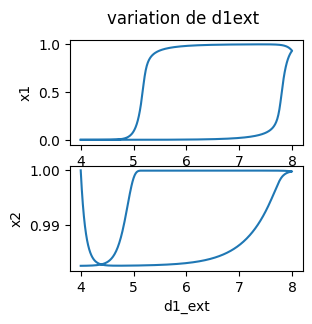

In [42]:
def d_ext_varying(t):
    d1_ext = (0.1*t+4)*(t<40)+(8-0.1*(t-40))*(t>=40)
    d2_ext = 8.0*np.ones(np.shape(t))
    return np.array([d1_ext,d2_ext])

def f_d_ext_varying(t,x):
    return -x + sigmoid(np.dot(W,x)+d_ext_varying(t))

x0 = np.array([0.0,1.0])
dt = 0.1
t0, tf = 0.0, 80.0
time, x = solve_euler_explicit(f_d_ext_varying, x0, dt, t0, tf)
x1=[x[i][0] for i in range(len(x))]
x2=[x[i][1] for i in range(len(x))]
d1_ext=[d_ext_varying(t)[0] for t in time]

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle("variation de d1ext")
ax1.plot(d1_ext,x1)
ax1.set(xlabel="d1_ext",ylabel="x1")
ax2.plot(d1_ext,x2)
ax2.set(xlabel="d1_ext",ylabel="x2")

plt.show()



Bendixon et cycle limite
============================

On cherche maintenant à faire apparaître un cycle limite oscillatoire. On s'appuie pour cela sur le théorème de *Bendixon* qui décrit le comportement possible de solutions bornées d'équations différentielles en dimension 2:

    ''Pour une équation différentielle de dimension 2 définie par une fonction continument différentiable, toute solution maximale bornée converge soit vers un point soit vers une fonction périodique du temps appelée *cycle limite*''
    
**Question 8** Justifier que l'on recherche alors une valeur de $d_{\rm ext}$ pour laquelle le système admet un seul point d'équilibre et pour laquelle ce point est instable. 

**Question 9** La fonction ci-dessous permet de tracer les zéros de la dynamique comme ci-dessus mais superposés aux zones où la trace de la jacobienne de $f$ est strictement négative et son déterminant strictement positif. Compléter le calcul de la jacobienne et proposer une méthode empirique pour trouver une valeur de $d_{\rm ext}$ donnant un cycle limite. Vérifier en simulation l'apparition de ce cycle limite.

In [11]:
def jacobian_dynamics(x1,x2,d_ext):
    return # A COMPLETER

def plot_zero_locus_stabilite(d_ext):
    N = 100
    grid_x1 = np.linspace(-0.1,2.0,N)
    grid_x2 = np.linspace(-2.0,2.0,N)
    X1, X2 = np.meshgrid(grid_x1,grid_x2)

    X1dot = -X1 + sigmoid(W[0,0]*X1 + W[0,1]*X2 + d_ext[0])
    X2dot = -X2 + sigmoid(W[1,0]*X1 + W[1,1]*X2 + d_ext[1])

    # compute trace and determinant of jacobian matrix on the grid
    tr = np.zeros((N,N))
    deter = np.zeros((N,N))
    for i in np.arange(N):
        for j in np.arange(N):
            tr[i,j] = np.trace(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))
            deter[i,j] = np.linalg.det(jacobian_dynamics(X1[i,j],X2[i,j],d_ext))

    # plot zone where  the trace of the jacobian is negative and its determinant positive
    plt.figure()
    plt.pcolormesh(X1,X2,(tr<0)*(deter>0))

    # root locus plot
    C1 = plt.contour(X1, X2, X1dot, 0, colors = 'red')
    C2 = plt.contour(X1, X2, X2dot, 0, colors = 'green')
    h1,_ = C1.legend_elements()
    h2,_ = C2.legend_elements()
    plt.grid(True)
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend([h1[0],h2[0]],['$\dot x_1 = 0$','$\dot x_2 = 0$'])
    plt.title("Zero locus for $d_{ext} =$ "+ str(d_ext))
    plt.show()

    return

plot_zero_locus_stabilite(np.array([4.0,1.0]))

ValueError: diag requires an array of at least two dimensions